# Simple Example of a Simulation in jf1uids

## Imports

In [1]:
# %pip install ../

import jax.numpy as jnp


from jf1uids import CARTESIAN
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids import get_helper_data
from jf1uids.fluid_equations.fluid import construct_primitive_state3D
from jf1uids import time_integration

import jax
from jf1uids.time_stepping.time_integration import _time_integration_fixed_steps3D

jax.config.update("jax_enable_x64", False)

from jf1uids import get_registered_variables


import matplotlib.pyplot as plt

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters.

First we get the configuration of the simulation, which contains parameters that typically do not change between simulations, changing which requires (just-in-time)-recompilation.

In [2]:
from jf1uids.option_classes.simulation_config import BACKWARDS


config = SimulationConfig(
    dimensionality = 3,
    geometry = CARTESIAN,
    num_cells = 96,
    num_ghost_cells = 1,
    num_timesteps = 500,
    differentiation_mode = BACKWARDS,
    first_order_fallback = True,
    fixed_timestep = False
)

Next we setup the simulation parameters, things we might vary

In [3]:

params = SimulationParams(
    t_end = 0.1, # the typical value for a shock test
    C_cfl = 0.4
)

With this we generate some helper data, like the cell centers etc.

In [4]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

2025-01-30 15:02:12.875568: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Next we setup the shock initial conditions, a uniform background with a sedov blast wave in the center.

In [5]:
# setup the initial fluid state in terms of rho, u, p
rho = jnp.ones((config.num_cells, config.num_cells, config.num_cells)) * 1
u_x = jnp.zeros((config.num_cells, config.num_cells, config.num_cells))
u_y = jnp.zeros((config.num_cells, config.num_cells, config.num_cells))
u_z = jnp.zeros((config.num_cells, config.num_cells, config.num_cells))
p = jnp.ones((config.num_cells, config.num_cells, config.num_cells)) * 1e-5

# # initialize sedov taylor blast wave
num_cells = config.num_cells
# rho = rho.at[num_cells//2 - 2:num_cells//2 + 3, num_cells//2 - 2:num_cells//2 + 3, num_cells//2 - 2:num_cells//2 + 3].set(1.0)
# p = p.at[num_cells//2 - 2:num_cells//2 + 3, num_cells//2 - 2:num_cells//2 + 3, num_cells//2 - 2:num_cells//2 + 3].set(1.0)
# # get initial state
# initial_state = construct_primitive_state3D(rho, u_x, u_y, u_z, p, registered_variables)

injection_radius = 0.1
injection_mask = helper_data.r <= injection_radius
# rho = rho.at[injection_mask].set(1.0)
p = p.at[injection_mask].set(1.0)

initial_state = construct_primitive_state3D(rho, u_x, u_y, u_z, p, registered_variables)

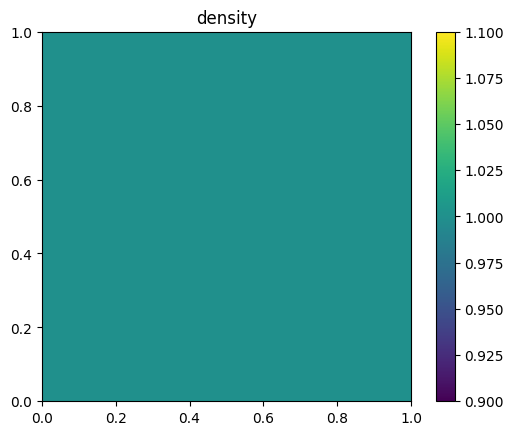

In [6]:
# plot a slice through the density
plt.title("density")
plt.imshow(initial_state[0, :, :, config.num_cells//2], origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()

## Running the simulation

In [7]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

nan


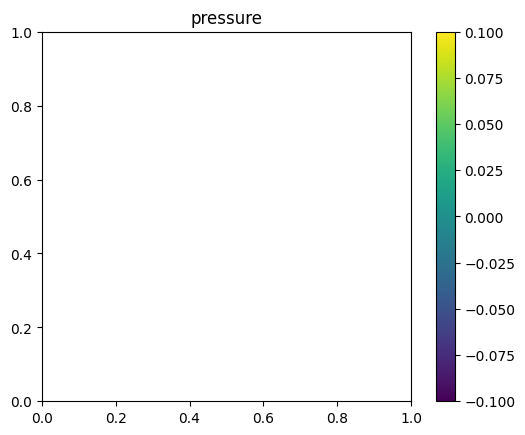

In [8]:
# plot a slice through the density
plt.title("pressure")
a = num_cells // 2 - 10
b = num_cells // 2 + 10
plt.imshow(final_state[registered_variables.pressure_index, :, :, num_cells // 2], origin='lower', extent=[0, 1, 0, 1])

# mark cell 30, 35, 35
# plt.scatter([35 / num_cells], [35 / num_cells], color='red')
plt.colorbar()
print(final_state[registered_variables.pressure_index, 30, 35, 35])

In [9]:
# # cut a 1d slice out of the final state
# from jf1uids.fluid_equations.euler import _euler_flux, _euler_flux3D
# from jf1uids.fluid_equations.fluid import total_energy_from_primitives

# final_state_x = final_state.at[[2,3], :, :, :].set(0.0)

# cut_state = final_state_x[[0,1,4], num_cells // 2, num_cells // 2, :]
# flux_1d = _euler_flux(cut_state, params.gamma, registered_variables._replace(velocity_index=1, pressure_index=2))

# flux3d = _euler_flux3D(final_state_x, params.gamma, registered_variables, registered_variables.velocity_index.x)
# flux_cut = flux3d[[0,1,4], num_cells // 2, num_cells // 2, :]

# # check if the fluxes are the same
# print(flux_1d - flux_cut)

# # rho = final_state_x[registered_variables.density_index]
# # p = final_state_x[registered_variables.pressure_index]
# # u = jnp.sqrt(final_state_x[registered_variables.velocity_index.x]**2 + final_state_x[registered_variables.velocity_index.y]**2 + final_state_x[registered_variables.velocity_index.z]**2)

# # # calculate the total energy
# # E = total_energy_from_primitives(rho, u, p, params.gamma)

# # print(E[num_cells // 2, num_cells // 2, :])

# # # energy of cut state
# # E_cut = total_energy_from_primitives(cut_state[0], cut_state[1], cut_state[2], params.gamma)
# # print(E_cut)

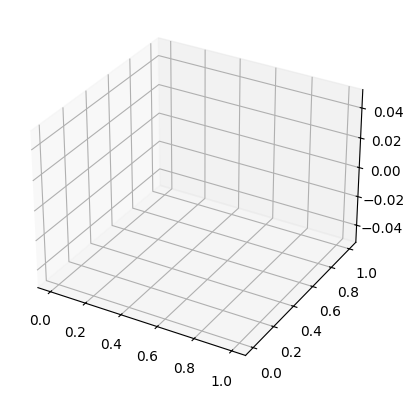

In [10]:
# plot final_state[registered_variables.pressure_index, num_cells // 2, :, :] as a 3D surface

ax, fig = plt.subplots(subplot_kw={'projection': '3d'})
x = jnp.linspace(0, 1, num_cells)
y = jnp.linspace(0, 1, num_cells)
X, Y = jnp.meshgrid(x, y)
Z = final_state[registered_variables.pressure_index, num_cells // 2, :, :]
fig.plot_surface(X, Y, Z, cmap='viridis')

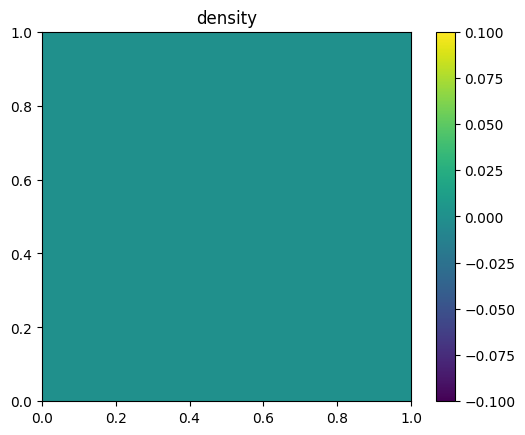

In [11]:
plt.title("density")
plt.imshow(final_state[0, :, 30, :], origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()

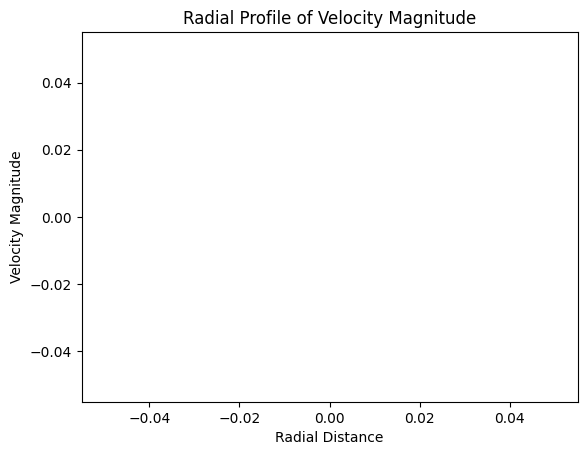

In [12]:
# Calculate the velocity magnitude
velocity_magnitude = jnp.sqrt(final_state[registered_variables.velocity_index.x]**2 + final_state[registered_variables.velocity_index.y]**2 + final_state[registered_variables.velocity_index.z]**2)

# Calculate the radial distance
r = helper_data.r

# Flatten the arrays for plotting
r_flat = r.flatten()
velocity_magnitude_flat = velocity_magnitude.flatten()

# Plot the radial profile
plt.figure()
plt.scatter(r_flat, velocity_magnitude_flat, s=1)
plt.xlabel('Radial Distance')
plt.ylabel('Velocity Magnitude')
plt.title('Radial Profile of Velocity Magnitude')
plt.show()